##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [1]:
import pandas as pd

train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')


# Transform dataset to balanced distribution

In [2]:
print("length of positive sentiments", len(train_data[train_data['sentiment']=="positive"]))
print("length of neutral sentiments", len(train_data[train_data['sentiment']=="neutral"]))
print("length of negative sentiments", len(train_data[train_data['sentiment']=="negative"]))

neutral_counter = 0
positive_counter = 0
drop_indices = []
for index, row in train_data.iterrows():
    if (row['sentiment'] == 'neutral') and (neutral_counter > 3715):
        drop_indices.append(index)
        neutral_counter += 1
    elif row['sentiment'] == 'neutral':
        neutral_counter += 1
    elif (row['sentiment'] == 'positive') and (positive_counter > 3715):
        drop_indices.append(index)
        positive_counter += 1
    elif row['sentiment'] == 'positive':
        positive_counter += 1

train_data = train_data.drop(drop_indices)


length of positive sentiments 5428
length of neutral sentiments 12659
length of negative sentiments 3715


Then we separate the tweet text and the label (sentiment). 

In [3]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))


Train length: 11147
Test length: 6099


# Visualisation

[Text(0.5, 1.0, 'train_data sentiments')]

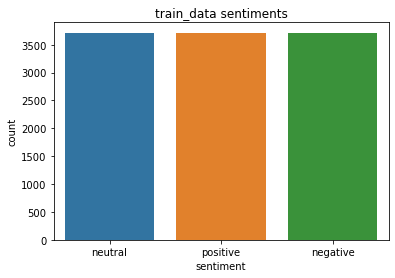

In [4]:
import seaborn as sns
sns.countplot(x='sentiment', data=train_data).set(title="train_data sentiments")


# Preprocess

In [5]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to /Users/kennyyu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kennyyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kennyyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kennyyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
X_train_preprocessed = []
stopWords = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

for tweet in X_train_raw:
    tweet = tweet.lower()
    # Remove usernames
    tweet = re.sub(r'@[^ ]* |$',' ', tweet)
    # Remove URLs
    tweet = re.sub(r'http.?:[^ ]*( |"|$)' ,' ', tweet)
    # Remove non-letters
    tweet = re.sub(r'[^a-z]' ,' ', tweet)
    # Remove letters that occur more than two times in a row
    tweet = re.sub(r'([a-z])\1{2,}' ,r'\1', tweet)
    # remove extra spaces
    tweet = re.sub(r' {2,}' ,' ', tweet)
    
    # Tokenization
    wordList = nltk.word_tokenize(tweet)
    # Lemmatization
    wordList = [wordnet_lemmatizer.lemmatize(word) for word in wordList]
    # Removing stop words
    filteredList = [w for w in wordList if not w in stopWords]
    
    X_train_preprocessed.append(filteredList)

X_train_preprocessed = [' '.join(item) for item in X_train_preprocessed]


# BOW

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

BoW_vectorizer = CountVectorizer(ngram_range=(1,2))

#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW_raw = BoW_vectorizer.fit_transform(X_train_raw)
X_train_BoW_preprocessed = BoW_vectorizer.fit_transform(X_train_preprocessed)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = BoW_vectorizer.transform(X_test_raw)
X_test_BoW.shape


(6099, 98870)

# TFIDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_tfidf_raw = tfidf_vectorizer.fit_transform(X_train_raw)
X_train_tfidf_preprocessed = tfidf_vectorizer.fit_transform(X_train_preprocessed)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)
X_test_tfidf.shape


(6099, 98870)

# Feature Selection

In [9]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import KFold
import warnings

CV = 5

warnings.filterwarnings('ignore')

models = [MultinomialNB(),
          svm.LinearSVC(max_iter=10000),
          LogisticRegression(max_iter = 10000)]

titles = ['MNB',
          'Linear SVM',
          'Logistic regression']


for k in [1000, 3000, 5000, 10000]:
    x2 = SelectKBest(chi2, k=k)
    X_train_BoW_x2 = x2.fit_transform(X_train_BoW_preprocessed, Y_train)
    X_train_tfidf_x2 = x2.fit_transform(X_train_tfidf_preprocessed, Y_train)

    mi = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_BoW_mi = mi.fit_transform(X_train_BoW_preprocessed, Y_train)
    X_train_tfidf_mi = mi.fit_transform(X_train_tfidf_preprocessed, Y_train)

    X_BoWs = [X_train_BoW_preprocessed, X_train_BoW_x2, X_train_BoW_mi]
    X_tfidfs = [X_train_tfidf_preprocessed, X_train_tfidf_x2, X_train_tfidf_mi]

    X_names = ['complete', 'x2', 'mi']

    print('\n--------------------------------------- K =', k,'------------------------------')
    print("Using BoW:")

    for title, model in zip(titles, models):
        print('\n=========',title, '(with k=',k,'features): ')
        for X_name, X_train_t in zip(X_names, X_BoWs):
            
            accuracy = cross_val_score(model, X_train_t, Y_train, cv=KFold(n_splits=CV, shuffle=True))
            print(X_name, 'accuracy is:', np.mean(accuracy))

    print("\nUsing TFIDF:")

    for title, model in zip(titles, models):
        print('\n=========',title, '(with k=',k,'features): ')
        for X_name, X_train_t in zip(X_names, X_tfidfs):
            
            accuracy = cross_val_score(model, X_train_t, Y_train, cv=KFold(n_splits=CV, shuffle=True))
            print(X_name, 'accuracy is:', np.mean(accuracy))
            

In [10]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
# chi-square
selector_BoW = SelectKBest(chi2, k=3000)
X_train_BoW_preprocessed = selector_BoW.fit_transform(X_train_BoW_preprocessed,Y_train)

selector_tfidf = SelectKBest(chi2, k=3000)
X_train_tfidf_preprocessed = selector_tfidf.fit_transform(X_train_tfidf_preprocessed,Y_train)

X_test_new = selector_BoW.transform(X_test_BoW)


# 0-R

In [11]:
from sklearn.dummy import DummyClassifier
zero_r = DummyClassifier(strategy='most_frequent')

# Using BoW
zero_r_BoW_preprocessed = DummyClassifier(strategy='most_frequent')
zero_r_BoW_preprocessed.fit(X_train_BoW_preprocessed, Y_train)

# Using TFIDF
zero_r_tfidf_preprocessed = DummyClassifier(strategy='most_frequent')
zero_r_tfidf_preprocessed.fit(X_train_tfidf_preprocessed, Y_train)


DummyClassifier(strategy='most_frequent')

## Evaluation

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import numpy as np
import warnings
import time

warnings.filterwarnings('ignore')

def evaluate(clf, X, Y_train = Y_train, cv=5):
    accuracy = clf.score(X, Y_train)
    print("Training accuracy: ", accuracy)
    # Hiding warnings raised when precision or recall equal zero in some cases
    warnings.filterwarnings('ignore')
    scores = cross_val_score(clf, X, Y_train, cv=KFold(n_splits=cv, shuffle=True))
    print("Average cv accuracy: ", np.mean(scores))
    precision_macro = cross_val_score(clf, X, Y_train, scoring='precision_macro', cv=KFold(n_splits=cv, shuffle=True))
    print("Average cv precision (macro-averaging): ", np.mean(precision_macro))
    precision_weighted = cross_val_score(clf, X, Y_train, scoring='precision_weighted', cv=KFold(n_splits=cv, shuffle=True))
    print("Average cv precision (weighted averaging): ", np.mean(precision_weighted))
    recall_macro = cross_val_score(clf, X, Y_train, scoring='recall_macro', cv=KFold(n_splits=cv, shuffle=True))
    print("Average cv recall (macro-averaging): ", np.mean(recall_macro))
    recall_weighted = cross_val_score(clf, X, Y_train, scoring='recall_weighted', cv=KFold(n_splits=cv, shuffle=True))
    print("Average cv recall (weighted averaging): ", np.mean(recall_weighted))
    f1_macro = cross_val_score(clf, X, Y_train, scoring='f1_macro', cv=KFold(n_splits=cv, shuffle=True))
    print("Average cv f1-score (macro-averaging): ", np.mean(f1_macro))
    f1_weighted = cross_val_score(clf, X, Y_train, scoring='f1_weighted', cv=KFold(n_splits=cv, shuffle=True))
    print("Average cv f1-score (weighted averaging): ", np.mean(f1_weighted))
    y_pred = clf.predict(X)
    print("Confusion matrix:")
    print(confusion_matrix(Y_train, y_pred, labels=["positive", "neutral", "negative"]))
    

In [13]:
# Using BoW
print("Using BoW:")
evaluate(zero_r_BoW_preprocessed, X_train_BoW_preprocessed)
print()

# Using TFIDF
print("Using TFIDF:")
evaluate(zero_r_tfidf_preprocessed, X_train_tfidf_preprocessed)


Using BoW:
Training accuracy:  0.33336323674531265
Average cv accuracy:  0.3245713756897964
Average cv precision (macro-averaging):  0.10914756629052688
Average cv precision (weighted averaging):  0.1053250384433023
Average cv recall (macro-averaging):  0.3333333333333333
Average cv recall (weighted averaging):  0.3257384215809941
Average cv f1-score (macro-averaging):  0.1641410459606216
Average cv f1-score (weighted averaging):  0.16294786129485847
Confusion matrix:
[[   0 3716    0]
 [   0 3716    0]
 [   0 3715    0]]

Using TFIDF:
Training accuracy:  0.33336323674531265
Average cv accuracy:  0.32367491706349444
Average cv precision (macro-averaging):  0.107831821464712
Average cv precision (weighted averaging):  0.10610981414425655
Average cv recall (macro-averaging):  0.3333333333333333
Average cv recall (weighted averaging):  0.31613943391937105
Average cv f1-score (macro-averaging):  0.16362945259199313
Average cv f1-score (weighted averaging):  0.15838259184106013
Confusion ma

# Naive Bayes

In [13]:
from sklearn.naive_bayes import MultinomialNB

# Using BoW
NB_BoW_preprocessed = MultinomialNB().fit(X_train_BoW_preprocessed, Y_train)

#Using TFIDF
NB_tfidf_preprocessed = MultinomialNB().fit(X_train_tfidf_preprocessed, Y_train)


# Using BoW
print("Using BoW:")
evaluate(NB_BoW_preprocessed, X_train_BoW_preprocessed)
print()

# Using TFIDF
print("Using TFIDF:")
evaluate(NB_tfidf_preprocessed, X_train_tfidf_preprocessed)


Using BoW:
Training accuracy:  0.7117610119314614
Average cv accuracy:  0.6613435210947417
Average cv precision (macro-averaging):  0.6530480932316254
Average cv precision (weighted averaging):  0.653453155813154
Average cv recall (macro-averaging):  0.6608041489758814
Average cv recall (weighted averaging):  0.659549597941525
Average cv f1-score (macro-averaging):  0.65132901288805
Average cv f1-score (weighted averaging):  0.6534559576978187
Confusion matrix:
[[2964  466  286]
 [ 794 2016  906]
 [ 385  376 2954]]

Using TFIDF:
Training accuracy:  0.7033282497532969
Average cv accuracy:  0.6544357601691522
Average cv precision (macro-averaging):  0.6503723648618175
Average cv precision (weighted averaging):  0.6483688530412516
Average cv recall (macro-averaging):  0.6551361539274271
Average cv recall (weighted averaging):  0.6523734627323882
Average cv f1-score (macro-averaging):  0.6434285541135356
Average cv f1-score (weighted averaging):  0.6427336095340426
Confusion matrix:
[[3017

# Time Complexity

In [15]:
t0 = time.time()
MultinomialNB().fit(X_train_BoW_preprocessed, Y_train)
t1 = time.time() - t0
print("Execution time is: {} s".format(round(t1,3)))


Execution time is: 0.011 s


# Learning Curve

(0.0, 1.0)

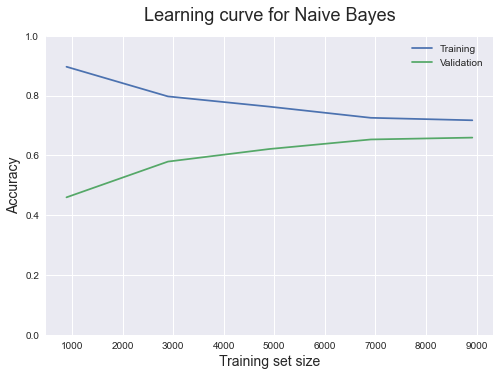

In [14]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = MultinomialNB(),
    X = X_train_BoW_preprocessed,
    y = Y_train, cv = 5)

train_scores_mean = train_scores.mean(axis=1)
validation_scores_mean = validation_scores.mean(axis=1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curve for Naive Bayes', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)


# SVM

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['linear','rbf','poly'],'C':[1.0],'max_iter':[10000]}
SVCmodel = SVC()
clf = GridSearchCV(SVCmodel,parameters)
clf.fit(X_train_BoW_preprocessed, Y_train)
clf.best_params_


In [19]:
t0 = time.time()
SVC(kernel='linear',max_iter=10000).fit(X_train_BoW_preprocessed, Y_train)
t1 = time.time() - t0
print("Execution time is: {} s".format(round(t1,3)))


Execution time is: 4.581 s


In [18]:
SVM_BoW = SVC(kernel='linear',max_iter=10000).fit(X_train_BoW_preprocessed, Y_train)
SVM_tfidf = SVC(kernel='linear',max_iter=10000).fit(X_train_tfidf_preprocessed, Y_train)

# Using BoW
print("Using BoW:")
evaluate(SVM_BoW, X_train_BoW_preprocessed)
print()

# Using TFIDF
print("Using TFIDF:")
evaluate(SVM_tfidf, X_train_tfidf_preprocessed)


Using BoW:
Training accuracy:  0.8199515564725935
Average cv accuracy:  0.6520144769216223
Average cv precision (macro-averaging):  0.6571270208453037
Average cv precision (weighted averaging):  0.6520021132039023
Average cv recall (macro-averaging):  0.6543163268153114
Average cv recall (weighted averaging):  0.6534489716678034
Average cv f1-score (macro-averaging):  0.6550058970996597
Average cv f1-score (weighted averaging):  0.6547091681991661
Confusion matrix:
[[3051  529  136]
 [ 381 2915  420]
 [ 132  409 3174]]

Using TFIDF:
Training accuracy:  0.7041356418767382
Average cv accuracy:  0.6434019961091764
Average cv precision (macro-averaging):  0.6538353808626278
Average cv precision (weighted averaging):  0.6538164220160179
Average cv recall (macro-averaging):  0.645032746351621
Average cv recall (weighted averaging):  0.6440306035202499
Average cv f1-score (macro-averaging):  0.6446072215788735
Average cv f1-score (weighted averaging):  0.6445577579987305
Confusion matrix:
[[2

# Learning Curve

(0.0, 1.0)

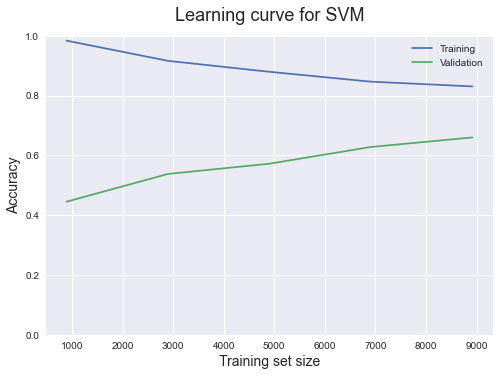

In [16]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = SVC(kernel='linear',max_iter=10000),
    X = X_train_BoW_preprocessed,
    y = Y_train, cv = 5)

train_scores_mean = train_scores.mean(axis=1)
validation_scores_mean = validation_scores.mean(axis=1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curve for SVM', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)


# ROC Curve

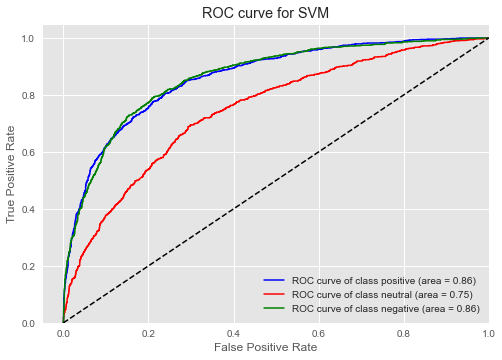

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
plt.style.use('ggplot')

X = X_train_BoW_preprocessed
y = Y_train

# Binarize the output
y = label_binarize(y, classes=['positive','neutral','negative'])
labels = ['positive','neutral','negative']
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=0)

classifier = OneVsRestClassifier(SVC(kernel='linear',max_iter=10000))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVM')
plt.legend(loc="lower right")
plt.show()


# Logistic Regression

In [22]:
parameters = {'solver':['lbfgs','saga','sag','newton-cg'],'penalty': ['l2','none'],'multi_class':['multinomial','ovr'],'max_iter':[10000]}
lgr = LogisticRegression()
clf = GridSearchCV(lgr,parameters)
clf.fit(X_train_BoW_preprocessed, Y_train)
clf.best_params_


In [19]:
t0 = time.time()
LogisticRegression(solver='lbfgs',multi_class='ovr',penalty='none',max_iter=10000).fit(X_train_BoW_preprocessed, Y_train)
t1 = time.time() - t0
print("Execution time is: {} s".format(round(t1,3)))


Execution time is: 8.524 s


In [21]:
lgr = LogisticRegression(solver='lbfgs',multi_class='ovr',penalty='none',max_iter=10000)
lgr_BoW = LogisticRegression(solver='lbfgs',multi_class='ovr',penalty='none',max_iter=10000).fit(X_train_BoW_preprocessed, Y_train)
lgr_tfidf = LogisticRegression(solver='lbfgs',multi_class='ovr',penalty='none',max_iter=10000).fit(X_train_tfidf_preprocessed, Y_train)

# Using BoW
print("Using BoW:")
evaluate(lgr_BoW, X_train_BoW_preprocessed)
print()

# Using TFIDF
print("Using TFIDF:")
evaluate(lgr_tfidf, X_train_tfidf_preprocessed)


Using BoW:
Training accuracy:  0.845249843007087
Average cv accuracy:  0.6515652819438829
Average cv precision (macro-averaging):  0.6527597009415592
Average cv precision (weighted averaging):  0.6537783527871964
Average cv recall (macro-averaging):  0.6465739179702081
Average cv recall (weighted averaging):  0.6461828687078403
Average cv f1-score (macro-averaging):  0.6522088034004112
Average cv f1-score (weighted averaging):  0.6475115258843902
Confusion matrix:
[[3184  446   86]
 [ 372 2996  348]
 [ 109  364 3242]]

Using TFIDF:
Training accuracy:  0.829550551717951
Average cv accuracy:  0.6713019773994251
Average cv precision (macro-averaging):  0.6762827290670291
Average cv precision (weighted averaging):  0.6725346705972406
Average cv recall (macro-averaging):  0.6790580231664396
Average cv recall (weighted averaging):  0.6738141940623699
Average cv f1-score (macro-averaging):  0.6778904134878798
Average cv f1-score (weighted averaging):  0.6739325866459158
Confusion matrix:
[[30

(0.0, 1.0)

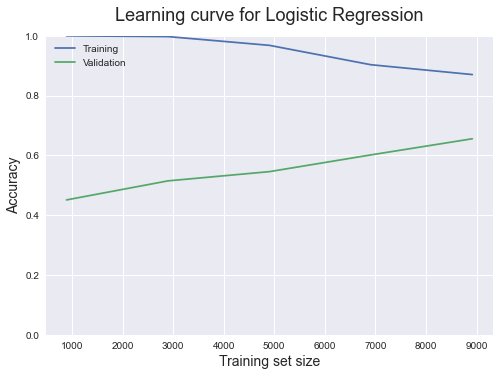

In [22]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = LogisticRegression(solver='lbfgs',multi_class='ovr',penalty='none',max_iter=10000),
    X = X_train_BoW_preprocessed,
    y = Y_train, cv = 5)

train_scores_mean = train_scores.mean(axis=1)
validation_scores_mean = validation_scores.mean(axis=1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curve for Logistic Regression', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)


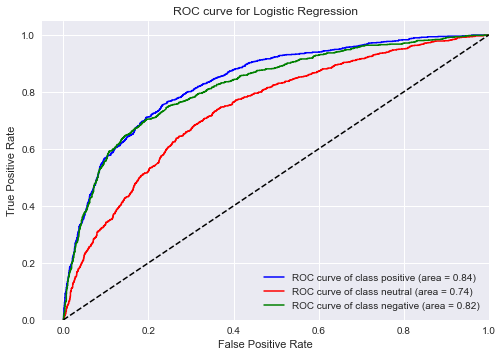

In [23]:
X = X_train_BoW_preprocessed
y = Y_train

# Binarize the output
y = label_binarize(y, classes=['positive','neutral','negative'])
labels = ['positive','neutral','negative']
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=0)

classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs',multi_class='ovr',penalty='none',max_iter=10000))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


# Stacking

In [24]:
from sklearn.ensemble import StackingClassifier

estimators = [('lgr',LogisticRegression(solver='lbfgs',multi_class='ovr',penalty='none',max_iter=10000)),('SVM',SVC(kernel='linear',max_iter=10000)),('MultiNB',MultinomialNB())]
stack_BoW = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression()).fit(X_train_BoW_preprocessed, Y_train)
stack_tfidf = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression()).fit(X_train_tfidf_preprocessed, Y_train)


In [25]:
t0 = time.time()
StackingClassifier(estimators=estimators,final_estimator=LogisticRegression()).fit(X_train_BoW_preprocessed, Y_train)
t1 = time.time() - t0
print("Execution time is: {} s".format(round(t1,3)))


Execution time is: 60.167 s


In [ ]:
# Using BoW
print("Using BoW:")
evaluate(stack_BoW, X_train_BoW_preprocessed)
print()

# Using TFIDF
print("Using TFIDF:")
evaluate(stack_tfidf, X_train_tfidf_preprocessed)


In [14]:
output_pd = pd.DataFrame({'id': test_data['id'],'sentiment': list(stack_BoW.predict(X_test_new))})
output_pd.to_csv('result.csv',index=False)